# Demonstration for Sobolev Functions on Intervals

This notebook demonstrates the capabilities of the `sobolev_functions.py` module, which provides mathematically rigorous Sobolev function objects that know about their parent Sobolev space.

## Mathematical Background

Sobolev spaces H^s([a,b]) are spaces of functions with s derivatives in L^2. They provide a natural framework for:
- Partial differential equations
- Bayesian inference with function-valued unknowns
- Regularization in inverse problems

Key properties:
- **Point evaluation**: Only well-defined for s > 1/2 on intervals
- **Embedding**: H^s ⊂ H^t for s > t
- **Regularity**: Higher s means smoother functions

## What This Demo Covers

1. **Space-aware functions**: Functions that know their Sobolev space
2. **Multiple representations**: Both callable and coefficient-based functions
3. **Mathematical operations**: Evaluation, integration, derivatives
4. **Domain operations**: Restriction and extension
5. **Arithmetic**: Addition and scalar multiplication
6. **Visualization**: Plotting functions and their properties

## 1. Import Required Modules and Setup

In [1]:
# Core scientific libraries
import numpy as np
import matplotlib.pyplot as plt
from scipy.integrate import quad
import warnings

# Our Sobolev function modules
from pygeoinf.other_space.interval_domain import IntervalDomain
from pygeoinf.other_space.interval_space import Sobolev
from pygeoinf.other_space.sobolev_functions import SobolevFunction

# Set up plotting
%matplotlib inline
plt.style.use('seaborn-v0_8-whitegrid')
plt.rcParams['figure.figsize'] = (10, 6)
plt.rcParams['font.size'] = 12

print("✓ All modules imported successfully!")
print(f"✓ NumPy version: {np.__version__}")
print(f"✓ Using matplotlib backend: {plt.get_backend()}")

✓ All modules imported successfully!
✓ NumPy version: 2.2.6
✓ Using matplotlib backend: inline


## 2. Create a Sobolev Space

First, we create a Sobolev space H^s([a,b]) using the `Sobolev.create_standard_sobolev` method. This creates the mathematical framework that our functions will live in.

In [2]:
# Create a Sobolev space H^2([0, π]) with dimension 50
sobolev_space = Sobolev.create_standard_sobolev(
    5,                 # Finite-dimensional approximation
    2,              # Sobolev order s = 2 (allows point evaluation since s > 1/2)
    interval=(0, np.pi),     # Domain [0, π]
    basis_type='fourier'  # Use Fourier basis for periodic Sobolev space
)

print(f"Created Sobolev space:")
print(f"  Order: {sobolev_space.order}")
print(f"  Dimension: {sobolev_space.dim}")
print(f"  Interval: {sobolev_space.interval_domain}")
print(f"  Space type: {type(sobolev_space).__name__}")

# Create another space with higher regularity for comparison
smooth_space = Sobolev.create_standard_sobolev(
    5,
    3,              # Higher regularity
    interval=(-1, 1),        # Different domain
    basis_type='fourier'     # Use Fourier basis for periodic Sobolev space
)

print(f"\nCreated smoother Sobolev space:")
print(f"  Order: {smooth_space.order}")
print(f"  Dimension: {smooth_space.dim}")
print(f"  Interval: {smooth_space.interval_domain}")

Created Sobolev space:
  Order: 2
  Dimension: 5
  Interval: [0.0, 3.141592653589793]
  Space type: Sobolev

Created smoother Sobolev space:
  Order: 3
  Dimension: 5
  Interval: [-1.0, 1.0]


## 3. Create Sobolev Functions (Coefficient and Callable)

We can create Sobolev functions in two ways:
1. **Coefficient-based**: Using basis function coefficients
2. **Callable-based**: Using mathematical function rules

Both approaches create functions that are aware of their Sobolev space.

In [3]:
# Method 1: Create function using coefficients
# Generate random coefficients with decay for smoothness
np.random.seed(42)  # For reproducibility
coefficients = np.random.randn(sobolev_space.dim) * np.exp(-np.arange(sobolev_space.dim) * 0.2)

f_coeffs = SobolevFunction(
    sobolev_space,
    coefficients=coefficients,
    name="Coefficient-based function"
)

print(f"Created coefficient-based function:")
print(f"  {f_coeffs}")
print(f"  Coefficients: {f_coeffs.coefficients}")
print(f"  Sobolev order: {f_coeffs.sobolev_order}")
print(f"  Domain: {f_coeffs.domain}")

# Method 2: Create function using callable
def callable_function(x):
    """A smooth oscillating function: x²sin(x)cos(2x)"""
    return np.sin(10 * x)

f_callable = SobolevFunction(
    sobolev_space,
    evaluate_callable=callable_function,
    name="Oscillating function"
)

print(f"\nCreated callable-based function:")
print(f"  {f_callable}")
print(f"  Has coefficients: {f_callable.coefficients is not None}")
print(f"  Has callable: {f_callable.evaluate_callable is not None}")

# Method 3: Create a simple polynomial function
def quadratic_function(x):
    """Simple quadratic: (x - π/2)²"""
    return (x - np.pi/2)**2

f_quad = SobolevFunction(
    sobolev_space,
    evaluate_callable=quadratic_function,
    name="Quadratic function"
)

print(f"\nCreated quadratic function:")
print(f"  {f_quad}")

# Create a function in the smoother space
def smooth_function(x):
    """Very smooth function: exp(-x²)cos(3x)"""
    return np.exp(-x**2) * np.cos(3*x)

f_smooth = SobolevFunction(
    smooth_space,
    evaluate_callable=smooth_function,
    name="Smooth function"
)

print(f"\nCreated smooth function:")
print(f"  {f_smooth}")
print(f"  Higher order: {f_smooth.sobolev_order}")

Created coefficient-based function:
  SobolevFunction(domain=[0.0, 3.141592653589793], order=2, name=Coefficient-based function)
  Coefficients: [ 0.49671415 -0.11320124  0.43415861  0.83585651 -0.10521189]
  Sobolev order: 2
  Domain: [0.0, 3.141592653589793]

Created callable-based function:
  SobolevFunction(domain=[0.0, 3.141592653589793], order=2, name=Oscillating function)
  Has coefficients: False
  Has callable: True

Created quadratic function:
  SobolevFunction(domain=[0.0, 3.141592653589793], order=2, name=Quadratic function)

Created smooth function:
  SobolevFunction(domain=[-1.0, 1.0], order=3, name=Smooth function)
  Higher order: 3


## 4. Evaluate Sobolev Functions at Points

Point evaluation is only mathematically valid for s > 1/2 on intervals. Our functions have s = 2 and s = 3, so point evaluation is well-defined.

### Tip: Use `f(x)` as a Shorthand for `f.evaluate(x)`

For any Sobolev function `f`, you can use the convenient syntax `f(x)` instead of `f.evaluate(x)`. This works for both callable-based and coefficient-based functions, and for both scalars and arrays.

In [4]:
# Single point evaluation
x_single = np.pi/2
print("Single point evaluation:")
print(f"f_callable({x_single:.3f}) = {f_callable(x_single):.6f}")
print(f"f_quad({x_single:.3f}) = {f_quad(x_single):.6f}")
print(f"f_coeffs({x_single:.3f}) = {f_coeffs(x_single):.6f}")

# Multiple point evaluation
x_points = np.array([0, np.pi/4, np.pi/2, 3*np.pi/4, np.pi])
print(f"\nMultiple point evaluation at {len(x_points)} points:")
for i, x in enumerate(x_points):
    print(f"  x[{i}] = {x:.3f}: f_oscillating = {f_callable(x):.6f}, f_quad = {f_quad(x):.6f}")

# Array evaluation for plotting
x_dense = np.linspace(0, np.pi, 100)
y_callable = f_callable.evaluate(x_dense)
y_quad = f_quad.evaluate(x_dense)

print(f"\nArray evaluation:")
print(f"  Evaluated at {len(x_dense)} points")
print(f"  f_callable range: [{y_callable.min():.3f}, {y_callable.max():.3f}]")
print(f"  f_quad range: [{y_quad.min():.3f}, {y_quad.max():.3f}]")

# Test domain checking
print(f"\nDomain checking:")
try:
    # This should work (point in domain)
    val_in = f_callable.evaluate(np.pi/2, check_domain=True)
    print(f"✓ Point π/2 in domain [0,π]: {val_in:.6f}")

    # This should fail (point outside domain)
    val_out = f_callable.evaluate(2*np.pi, check_domain=True)
    print(f"✗ This shouldn't print")
except ValueError as e:
    print(f"✓ Domain check caught out-of-domain point: {e}")

# Test low regularity error
try:
    # Create a space with s = 0.3 < 1/2
    low_reg_space = Sobolev.create_standard_sobolev(
        20, 0.3
    )
    low_reg_func = SobolevFunction(
        low_reg_space,
        evaluate_callable=lambda x: x**2
    )
    # This should fail
    val = low_reg_func.evaluate(0.5)
    print(f"✗ This shouldn't print")
except ValueError as e:
    print(f"✓ Low regularity check: {e}")

Single point evaluation:
f_callable(1.571) = 0.000000
f_quad(1.571) = 0.000000
f_coeffs(1.571) = 0.095016

Multiple point evaluation at 5 points:
  x[0] = 0.000: f_oscillating = 0.000000, f_quad = 2.467401
  x[1] = 0.785: f_oscillating = 1.000000, f_quad = 0.616850
  x[2] = 1.571: f_oscillating = 0.000000, f_quad = 0.000000
  x[3] = 2.356: f_oscillating = -1.000000, f_quad = 0.616850
  x[4] = 3.142: f_oscillating = -0.000000, f_quad = 2.467401

Array evaluation:
  Evaluated at 100 points
  f_callable range: [-1.000, 1.000]
  f_quad range: [0.000, 2.467]

Domain checking:
✓ Point π/2 in domain [0,π]: 0.000000
✓ Domain check caught out-of-domain point: Some points not in domain [0.0, 3.141592653589793]
✓ Low regularity check: Point evaluation not well-defined for H^0.3 on 1D domain. Requires s > 1/2.


In [5]:
# --- Coefficient-based function evaluation demo ---
print("\nCoefficient-based function evaluation:")

# Single point evaluation
val_coeff_single = f_coeffs(x_single)
print(f"f_coeffs({x_single:.3f}) = {val_coeff_single:.6f}")

# Multiple point evaluation
print(f"\nMultiple point evaluation at {len(x_points)} points:")
for i, x in enumerate(x_points):
    print(f"  x[{i}] = {x:.3f}: f_coeffs = {f_coeffs(x):.6f}")

# Array evaluation for plotting
y_coeffs = f_coeffs.evaluate(x_dense)
print(f"\nArray evaluation:")
print(f"  Evaluated at {len(x_dense)} points")
print(f"  f_coeffs range: [{y_coeffs.min():.3f}, {y_coeffs.max():.3f}]")



Coefficient-based function evaluation:
f_coeffs(1.571) = 0.095016

Multiple point evaluation at 5 points:
  x[0] = 0.000: f_coeffs = 1.219369
  x[1] = 0.785: f_coeffs = 0.618453
  x[2] = 1.571: f_coeffs = 0.095016
  x[3] = 2.356: f_coeffs = 0.988968
  x[4] = 3.142: f_coeffs = 1.445772

Array evaluation:
  Evaluated at 100 points
  f_coeffs range: [0.077, 1.505]


## 5. Plot Sobolev Functions

Visualize our Sobolev functions to understand their behavior over their domains.

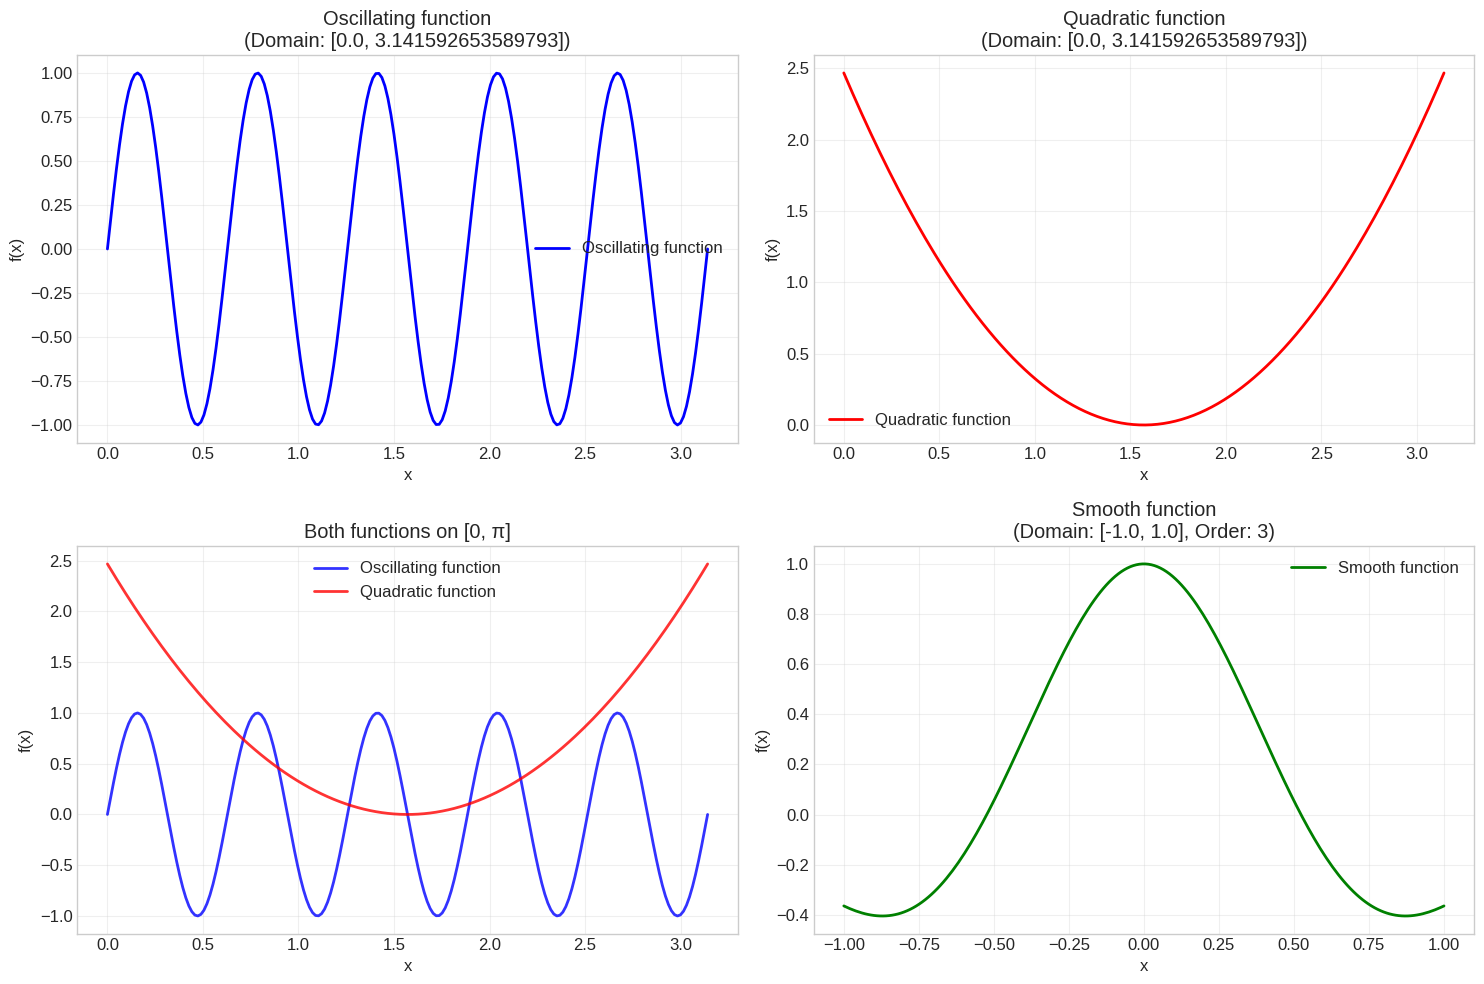

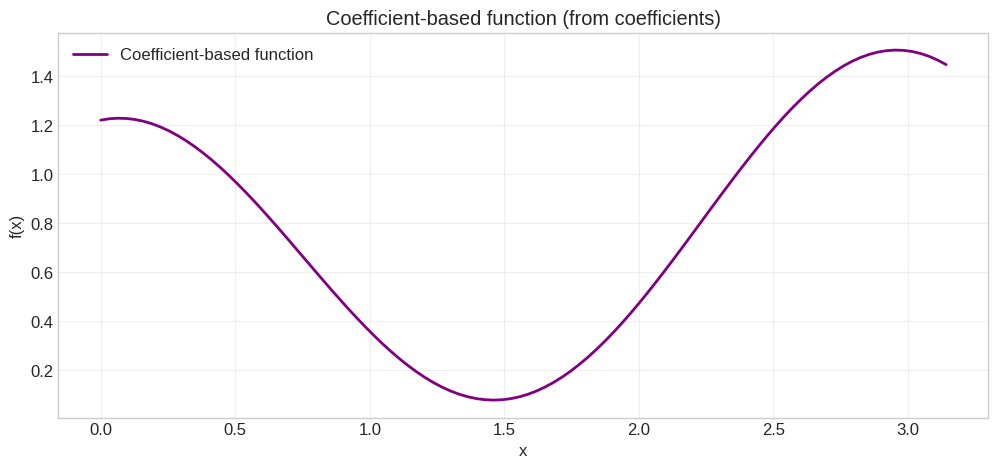

In [6]:
# Plot functions on [0, π]
plt.figure(figsize=(15, 10))

# Plot 1: Individual functions
plt.subplot(2, 2, 1)
f_callable.plot(n_points=200, color='blue', linewidth=2)
plt.title(f'{f_callable.name}\n(Domain: {f_callable.domain})')
plt.grid(True, alpha=0.3)

plt.subplot(2, 2, 2)
f_quad.plot(n_points=200, color='red', linewidth=2)
plt.title(f'{f_quad.name}\n(Domain: {f_quad.domain})')
plt.grid(True, alpha=0.3)

# Plot 3: Both functions together
plt.subplot(2, 2, 3)
f_callable.plot(n_points=200, color='blue', linewidth=2, alpha=0.8)
f_quad.plot(n_points=200, color='red', linewidth=2, alpha=0.8)
plt.title('Both functions on [0, π]')
plt.legend()
plt.grid(True, alpha=0.3)

# Plot 4: Smooth function on different domain
plt.subplot(2, 2, 4)
f_smooth.plot(n_points=200, color='green', linewidth=2)
plt.title(f'{f_smooth.name}\n(Domain: {f_smooth.domain}, Order: {f_smooth.sobolev_order})')
plt.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

# Coefficient-based function visualization attempt
plt.figure(figsize=(12, 5))

# Note: This might fail because coefficient evaluation is not fully implemented
f_coeffs.plot(n_points=100, color='purple', linewidth=2)
plt.title(f'{f_coeffs.name} (from coefficients)')
plt.grid(True, alpha=0.3)
plt.show()

## 6. Integrate Sobolev Functions

Demonstrate integration of Sobolev functions over their domains, both with and without weight functions. We compare numerical integration results to analytical values where possible, and show how to use weight functions and different integration methods.

In [7]:
# Integration demo: callable-based and coefficient-based Sobolev functions

# Callable-based function: f(x) = sin(10x) on [0, π]
I_callable = f_callable.integrate()
I_callable_analytical = 0  # \int_0^π x^2 dx
print(f"Callable-based: ∫ x^2 dx over [0,π] = {I_callable:.6f} (analytical: {I_callable_analytical:.6f})")

# Quadratic function integration
I_quad = f_quad.integrate()
I_quad_analytical = (np.pi**3)/12  # \int_0^π (x - π/2)² dx
print(f"Quadratic function: ∫ (x - π/2)² dx over [0,π] = {I_quad:.6f} (analytical: {I_quad_analytical:.6f})")

# Integration with a weight function: w(x) = 2x
w = lambda x: 2*x
I_weighted = f_callable.integrate(weight=w)
# Analytical: ∫_0^π sin(10x) * 2x dx = -π/5
I_weighted_analytical = -np.pi / 5  # This is the analytical result for the weighted integral
print(f"Callable-based weighted: ∫ x^2 * 2x dx over [0,1] = {I_weighted:.6f} (analytical: {I_weighted_analytical:.6f})")

Callable-based: ∫ x^2 dx over [0,π] = -0.000000 (analytical: 0.000000)
Quadratic function: ∫ (x - π/2)² dx over [0,π] = 2.583856 (analytical: 2.583856)
Callable-based weighted: ∫ x^2 * 2x dx over [0,1] = -0.628319 (analytical: -0.628319)


## 7. Restrict and Extend Sobolev Functions

Not implemented yet

## 8. Compute Weak Derivatives

Not implemented yet

## 9. Arithmetic Operations on Sobolev Functions

Demonstrate addition, scalar multiplication, and error handling for unsupported operations.

In [ ]:
# Test arithmetic operations
print("Arithmetic Operations on Sobolev Functions")
print("=" * 50)

# Addition of functions in the same space
print(f"1. Addition of functions in the same space:")
print(f"   f_callable: {f_callable.name}")
print(f"   f_quad: {f_quad.name}")
print(f"   Both in space with order {f_callable.sobolev_order}")

try:
    f_sum = f_callable + f_quad
    print(f"✓ Addition successful:")
    print(f"    Result: {f_sum}")
    print(f"    Same space: {f_sum.space == f_callable.space}")
    print(f"    Has callable: {f_sum.evaluate_callable is not None}")

    # Test evaluation of sum
    x_test = np.pi/3
    val_callable = f_callable.evaluate(x_test)
    val_quad = f_quad.evaluate(x_test)
    val_sum = f_sum.evaluate(x_test)
    expected_sum = val_callable + val_quad

    print(f"    Evaluation test at x = {x_test:.3f}:")
    print(f"      f_callable({x_test:.3f}) = {val_callable:.6f}")
    print(f"      f_quad({x_test:.3f}) = {val_quad:.6f}")
    print(f"      (f_callable + f_quad)({x_test:.3f}) = {val_sum:.6f}")
    print(f"      Expected: {expected_sum:.6f}")
    print(f"      Error: {abs(val_sum - expected_sum):.2e}")

except Exception as e:
    print(f"⚠ Addition failed: {e}")

# Scalar multiplication
print(f"\n2. Scalar multiplication:")
scalar = 2.5
try:
    f_scaled1 = scalar * f_callable  # Left multiplication
    f_scaled2 = f_callable * scalar  # Right multiplication

    print(f"✓ Scalar multiplication successful:")
    print(f"    {scalar} * {f_callable.name}: {f_scaled1}")
    print(f"    {f_callable.name} * {scalar}: {f_scaled2}")

    # Test evaluation
    x_test = np.pi/4
    val_orig = f_callable.evaluate(x_test)
    val_scaled1 = f_scaled1.evaluate(x_test)
    val_scaled2 = f_scaled2.evaluate(x_test)

    print(f"    Evaluation test at x = {x_test:.3f}:")
    print(f"      Original: {val_orig:.6f}")
    print(f"      {scalar} * f: {val_scaled1:.6f}")
    print(f"      f * {scalar}: {val_scaled2:.6f}")
    print(f"      Expected: {scalar * val_orig:.6f}")
    print(f"      Left mult error: {abs(val_scaled1 - scalar * val_orig):.2e}")
    print(f"      Right mult error: {abs(val_scaled2 - scalar * val_orig):.2e}")

except Exception as e:
    print(f"⚠ Scalar multiplication failed: {e}")

# Addition with constant
print(f"\n3. Addition with constants:")
constant = 1.0
try:
    f_plus_const = f_callable + constant
    print(f"✓ Constant addition successful:")
    print(f"    {f_callable.name} + {constant}: {f_plus_const}")

    # Test evaluation
    x_test = np.pi/6
    val_orig = f_callable.evaluate(x_test)
    val_plus_const = f_plus_const.evaluate(x_test)

    print(f"    Evaluation test at x = {x_test:.3f}:")
    print(f"      Original: {val_orig:.6f}")
    print(f"      f + {constant}: {val_plus_const:.6f}")
    print(f"      Expected: {val_orig + constant:.6f}")
    print(f"      Error: {abs(val_plus_const - (val_orig + constant)):.2e}")

except Exception as e:
    print(f"⚠ Constant addition failed: {e}")

# Test error cases
print(f"\n4. Error handling:")

# Addition of functions in different spaces
print(f"   a) Functions in different spaces:")
try:
    invalid_sum = f_callable + f_smooth  # Different spaces
    print(f"✗ This shouldn't succeed")
except ValueError as e:
    print(f"✓ Correctly caught incompatible spaces: {e}")

# Function multiplication (not implemented)
print(f"   b) Function multiplication (not implemented):")
try:
    invalid_product = f_callable * f_quad
    print(f"✗ This shouldn't succeed")
except NotImplementedError as e:
    print(f"✓ Correctly caught unimplemented operation: {e}")

# Invalid type operations
print(f"   c) Invalid type operations:")
try:
    invalid_op = f_callable + "invalid"
    print(f"✗ This shouldn't succeed")
except Exception as e:
    print(f"✓ Correctly caught invalid type: {type(e).__name__}: {e}")

# Coefficient-based arithmetic
print(f"\n5. Coefficient-based arithmetic:")
if f_coeffs.coefficients is not None:
    try:
        # Scalar multiplication of coefficient function
        f_coeffs_scaled = 3.0 * f_coeffs
        print(f"✓ Coefficient scalar multiplication:")
        print(f"    Original coefficients norm: {np.linalg.norm(f_coeffs.coefficients):.6f}")
        print(f"    Scaled coefficients norm: {np.linalg.norm(f_coeffs_scaled.coefficients):.6f}")
        print(f"    Ratio: {np.linalg.norm(f_coeffs_scaled.coefficients) / np.linalg.norm(f_coeffs.coefficients):.6f}")

        # Addition with another coefficient function
        f_coeffs2 = SobolevFunction(
            sobolev_space,
            coefficients=np.random.randn(sobolev_space.dim) * 0.1,
            name="Second coefficient function"
        )
        f_coeffs_sum = f_coeffs + f_coeffs2
        print(f"✓ Coefficient addition:")
        print(f"    Result has coefficients: {f_coeffs_sum.coefficients is not None}")
        print(f"    Coefficients shape: {f_coeffs_sum.coefficients.shape}")

    except Exception as e:
        print(f"⚠ Coefficient arithmetic failed: {e}")
else:
    print("⚠ No coefficient-based function available for testing")

Arithmetic Operations on Sobolev Functions
1. Addition of functions in the same space:
   f_callable: Oscillating function
   f_quad: Quadratic function
   Both in space with order 2
✓ Addition successful:
    Result: SobolevFunction(domain=[0.0, 3.141592653589793], order=2, name=None)
    Same space: True
    Has callable: True
    Evaluation test at x = 1.047:
      f_callable(1.047) = -0.866025
      f_quad(1.047) = 0.274156
      (f_callable + f_quad)(1.047) = -0.591870
      Expected: -0.591870
      Error: 0.00e+00

2. Scalar multiplication:
✓ Scalar multiplication successful:
    2.5 * Oscillating function: SobolevFunction(domain=[0.0, 3.141592653589793], order=2, name=None)
    Oscillating function * 2.5: SobolevFunction(domain=[0.0, 3.141592653589793], order=2, name=None)
    Evaluation test at x = 0.785:
      Original: 1.000000
      2.5 * f: 2.500000
      f * 2.5: 2.500000
      Expected: 2.500000
      Left mult error: 0.00e+00
      Right mult error: 0.00e+00

3. Additio


Visualizing arithmetic operations:


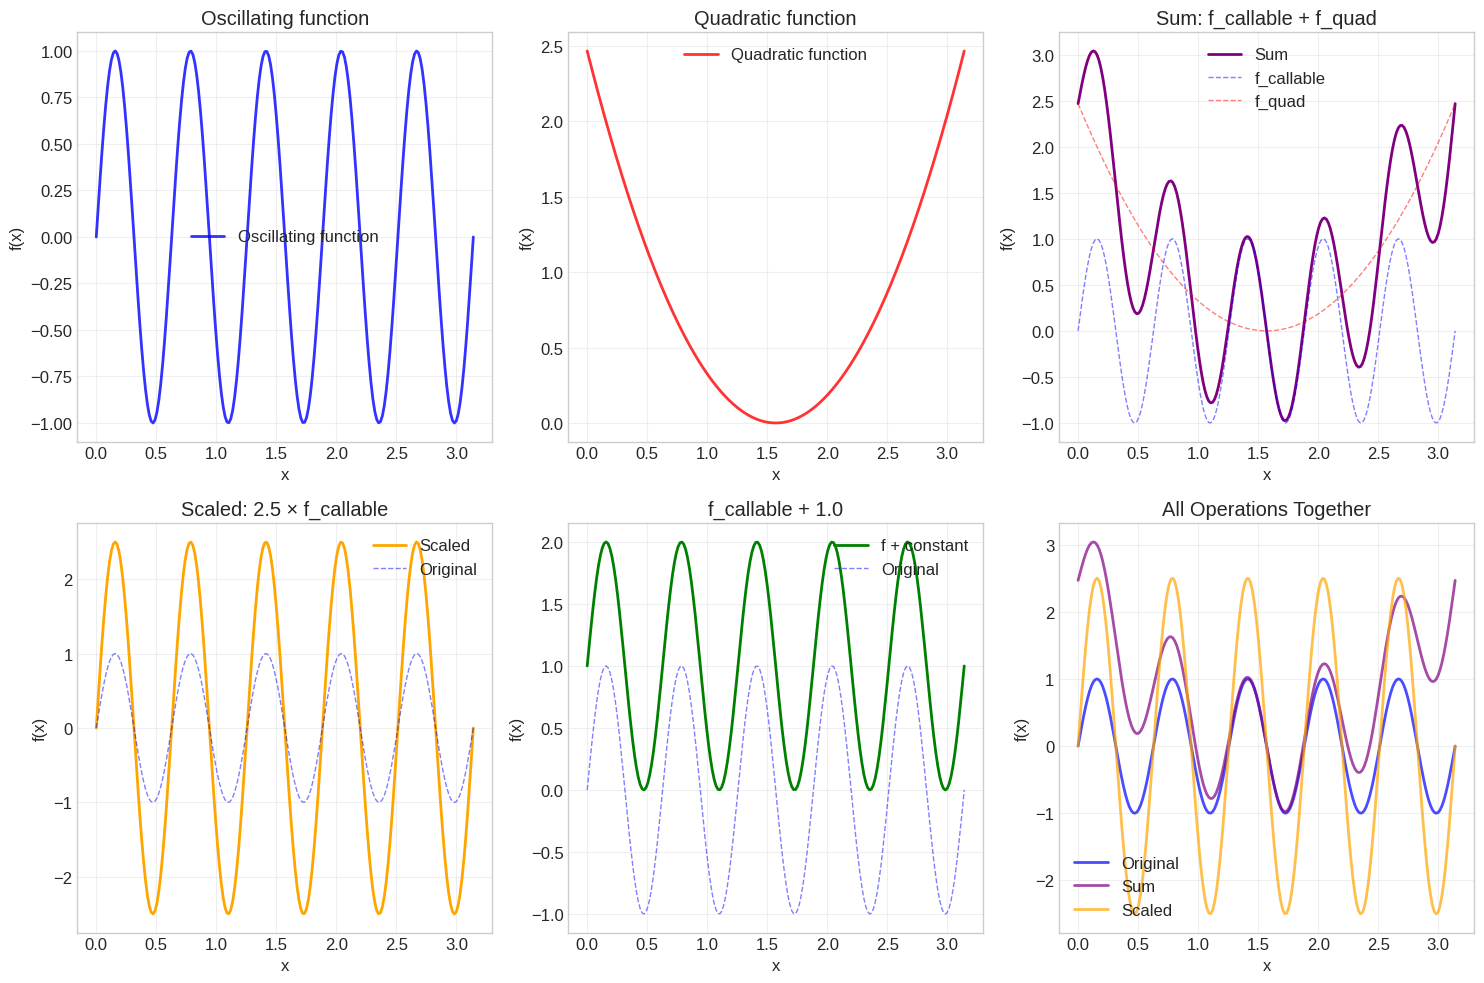

In [9]:
# Visualize arithmetic operations
print("\nVisualizing arithmetic operations:")

plt.figure(figsize=(15, 10))

# Plot original functions
plt.subplot(2, 3, 1)
f_callable.plot(n_points=200, color='blue', linewidth=2, alpha=0.8)
plt.title(f'{f_callable.name}')
plt.grid(True, alpha=0.3)

plt.subplot(2, 3, 2)
f_quad.plot(n_points=200, color='red', linewidth=2, alpha=0.8)
plt.title(f'{f_quad.name}')
plt.grid(True, alpha=0.3)

# Plot sum
plt.subplot(2, 3, 3)
try:
    f_sum.plot(n_points=200, color='purple', linewidth=2)
    f_callable.plot(n_points=200, color='blue', linewidth=1, alpha=0.5, linestyle='--')
    f_quad.plot(n_points=200, color='red', linewidth=1, alpha=0.5, linestyle='--')
    plt.title('Sum: f_callable + f_quad')
    plt.legend(['Sum', 'f_callable', 'f_quad'])
    plt.grid(True, alpha=0.3)
except:
    plt.text(0.5, 0.5, 'Sum\\nNot Available',
            transform=plt.gca().transAxes, ha='center', va='center',
            bbox=dict(boxstyle='round', facecolor='lightpink', alpha=0.8))
    plt.title('Sum (Not Available)')

# Plot scaled function
plt.subplot(2, 3, 4)
try:
    f_scaled1.plot(n_points=200, color='orange', linewidth=2)
    f_callable.plot(n_points=200, color='blue', linewidth=1, alpha=0.5, linestyle='--')
    plt.title(f'Scaled: {scalar} × f_callable')
    plt.legend(['Scaled', 'Original'])
    plt.grid(True, alpha=0.3)
except:
    plt.text(0.5, 0.5, 'Scaled\\nNot Available',
            transform=plt.gca().transAxes, ha='center', va='center',
            bbox=dict(boxstyle='round', facecolor='wheat', alpha=0.8))
    plt.title('Scaled (Not Available)')

# Plot function plus constant
plt.subplot(2, 3, 5)
try:
    f_plus_const.plot(n_points=200, color='green', linewidth=2)
    f_callable.plot(n_points=200, color='blue', linewidth=1, alpha=0.5, linestyle='--')
    plt.title(f'f_callable + {constant}')
    plt.legend(['f + constant', 'Original'])
    plt.grid(True, alpha=0.3)
except:
    plt.text(0.5, 0.5, 'Constant Add\\nNot Available',
            transform=plt.gca().transAxes, ha='center', va='center',
            bbox=dict(boxstyle='round', facecolor='lightgreen', alpha=0.8))
    plt.title('f + constant (Not Available)')

# Summary plot
plt.subplot(2, 3, 6)
try:
    f_callable.plot(n_points=200, color='blue', linewidth=2, alpha=0.7)
    if 'f_sum' in locals():
        f_sum.plot(n_points=200, color='purple', linewidth=2, alpha=0.7)
    if 'f_scaled1' in locals():
        f_scaled1.plot(n_points=200, color='orange', linewidth=2, alpha=0.7)
    plt.title('All Operations Together')
    plt.legend(['Original', 'Sum', 'Scaled'])
    plt.grid(True, alpha=0.3)
except:
    plt.text(0.5, 0.5, 'Summary\\nPlot Error',
            transform=plt.gca().transAxes, ha='center', va='center',
            bbox=dict(boxstyle='round', facecolor='lightgray', alpha=0.8))
    plt.title('Summary (Error)')

plt.tight_layout()
plt.show()